# DATA ACQUISITION & RFM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
full_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Olist-Ecomm-CaseStudy/crunchv3.csv')

In [ ]:
full_df["order_purchase_timestamp"] = pd.to_datetime(full_df["order_purchase_timestamp"])

latest_date = full_df["order_purchase_timestamp"].max()

# KMEANS

In [ ]:
customer_rfm = full_df.groupby("customer_id").agg(
    Recency=("order_purchase_timestamp", lambda x: (latest_date - x.max()).days),
    Frequency=("customer_id", "count"),
    Monetary=("payment_value", "sum")
).reset_index()

In [ ]:
# Add necessary columns from full_df
customer_rfm = pd.merge(customer_rfm, full_df[['order_id', 'customer_id','order_purchase_timestamp',
       'product_id', 'price', 'customer_city', 'customer_state',
       'product_category_name','Margin','Profit']], on='customer_id', how='left')

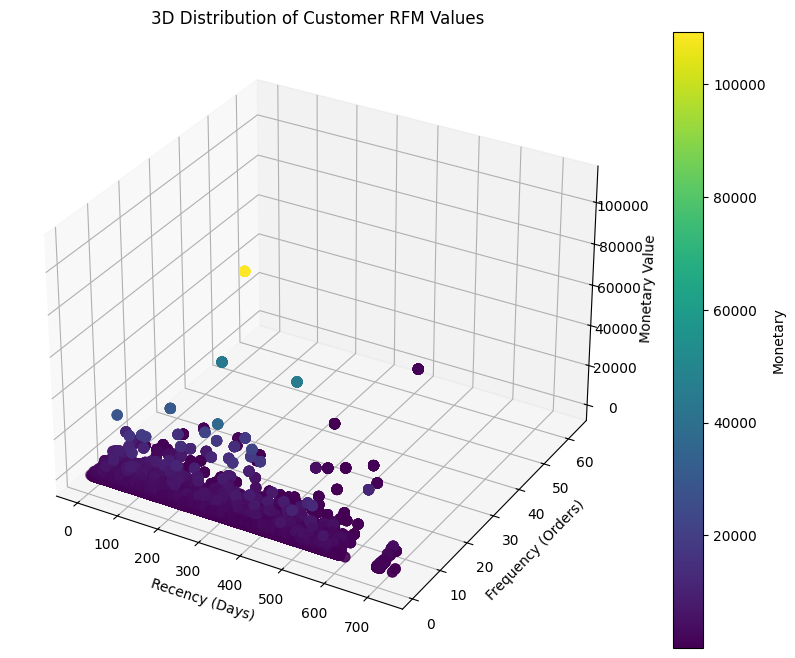

In [ ]:
# Three-dimensional distribution of the customer id

from mpl_toolkits.mplot3d import Axes3D

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of Recency, Frequency, and Monetary value
scatter = ax.scatter(customer_rfm['Recency'], customer_rfm['Frequency'], customer_rfm['Monetary'],
                     c=customer_rfm['Monetary'], cmap='viridis', s=50)

# Set axis labels
ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency (Orders)')
ax.set_zlabel('Monetary Value')
ax.set_title('3D Distribution of Customer RFM Values')

# Add a colorbar
fig.colorbar(scatter, ax=ax, label='Monetary')

plt.show()


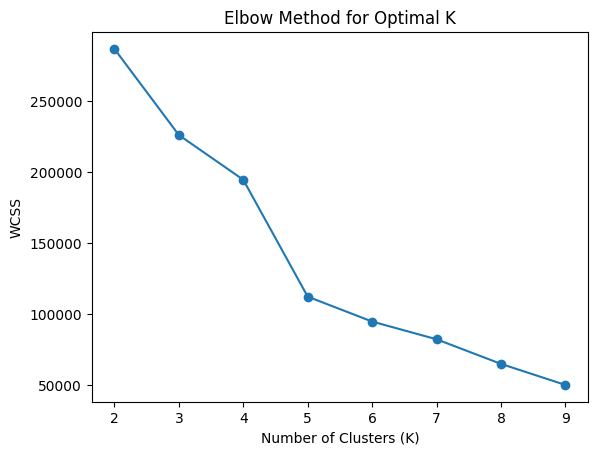

In [ ]:
# kmeans for customer_rfm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
kmeans_analysis = customer_rfm.copy()
rfm_features = kmeans_analysis[["Recency", "Frequency", "Monetary"]]
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_analysis["Cluster"] = kmeans.fit_predict(rfm_features)

# Scale data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Find optimal K using Elbow Method
wcss1 = []
for k in range(2, 10):
    kmeans1 = KMeans(n_clusters=k, random_state=42)
    kmeans1.fit(rfm_scaled)
    wcss1.append(kmeans1.inertia_)


# Plot Elbow Curve
plt.plot(range(2, 10), wcss1, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()

In [ ]:
# Apply K-Means with K = 5
kmeans1 = KMeans(n_clusters=5, random_state=42, n_init=10)
customer_rfm["Cluster"] = kmeans1.fit_predict(rfm_scaled)

In [ ]:
customer_rfm.head(5)

,customer_id,Recency,Frequency,Monetary,order_id,order_purchase_timestamp,product_id,price,customer_city,customer_state,product_category_name,Margin,Profit,Cluster
0,00012a2ce6f8dcda20d059ce98491703,292,1,114.74,5f79b5b0931d63f1a42989eb65b9da6e,2017-11-14 16:08:26,64315bd8c0c47303179dd2e25b579d00,89.80,osasco,SP,brinquedos,21.736099,24.94,0
1,000161a058600d5901f007fab4c27140,413,1,67.41,a44895d095d7e0702b6a162fa2dbeced,2017-07-16 09:40:32,84183944dc7cddca87a5d384452c1d3c,54.90,itapecerica,MG,beleza_saude,18.558077,12.51,0
2,0001fd6190edaaf884bcaf3d49edf079,551,1,195.42,316a104623542e4d75189bb372bc5f8d,2017-02-28 11:06:43,9df2b21ec85378d71df4404712e17478,179.99,nova venecia,ES,bebes,7.895814,15.43,0
3,0002414f95344307404f0ace7a26f1d5,382,1,179.35,5825ce2e88d5346438686b0bba99e5ee,2017-08-16 13:09:20,af3ec22cce878225aae6d9eb6c7a78eb,149.90,mendonca,MG,cool_stuff,16.420407,29.45,0
4,000379cdec625522490c315e70c7a9fb,153,1,107.01,0ab7fb08086d4af9141453c91878ed7a,2018-04-02 13:42:17,868b3136c5b206f91b8208fbfdf2cb7c,93.00,sao paulo,SP,cama_mesa_banho,13.092234,14.01,1


In [ ]:
cluster_summary = customer_rfm.groupby("Cluster").agg({"Recency": "mean", "Frequency": "mean", "Monetary": "mean", "Cluster":"count"})
cluster_summary = cluster_summary.rename(columns={"Cluster":"Count"})
cluster_summary

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,396.241741,1.381959,223.594408,48068
1,134.947771,1.321936,215.771094,64926
2,345.781915,31.388298,892.494574,376
3,254.294118,14.941176,48496.685882,68
4,235.606294,6.818881,3077.488013,4163


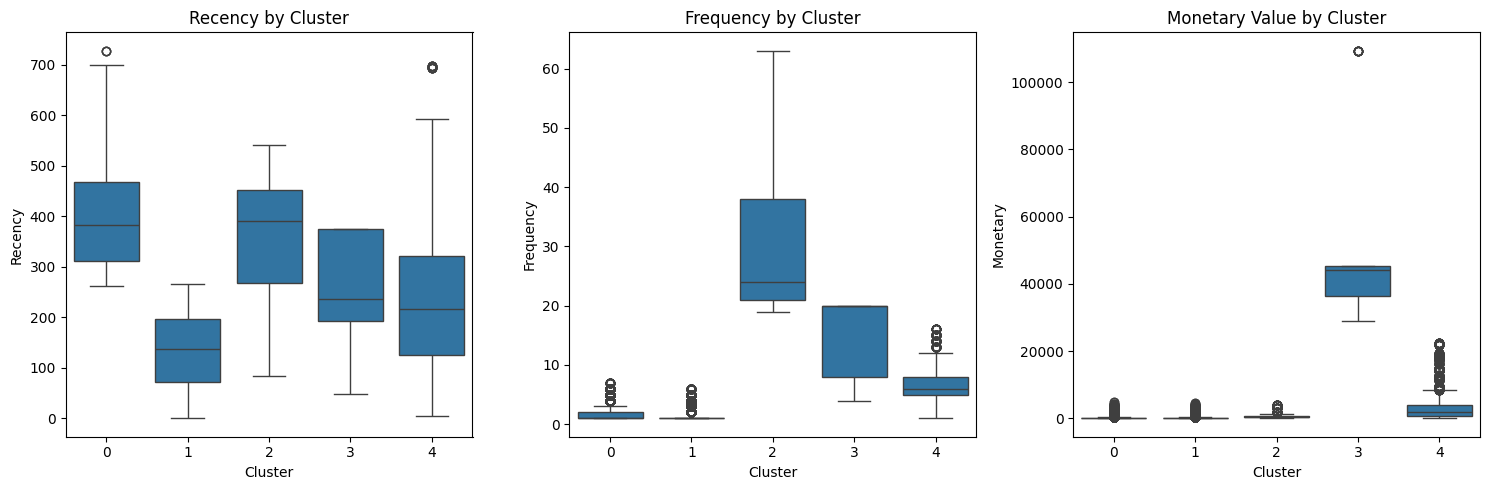

In [ ]:
# Visualize R,F,M for clusters  in separate box plots

import matplotlib.pyplot as plt
import seaborn as sns

# Create separate box plots for Recency, Frequency, and Monetary Value for each cluster
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency', data=customer_rfm)
plt.title('Recency by Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=customer_rfm)
plt.title('Frequency by Cluster')

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=customer_rfm)
plt.title('Monetary Value by Cluster')

plt.tight_layout()
plt.show()


In [ ]:
# Silhouette Score

from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
silhouette_avg = silhouette_score(rfm_scaled, customer_rfm["Cluster"])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5054180821162798


In [ ]:
# Davies-Bouldin Index

from sklearn.metrics import davies_bouldin_score

db_index1 = davies_bouldin_score(rfm_scaled, customer_rfm["Cluster"])
print(f"Davies-Bouldin Index: {db_index1}")

Davies-Bouldin Index: 0.7849240243092679


In [ ]:
from sklearn.metrics import silhouette_samples

# Assuming 'labels' is your cluster assignments and 'data' is your scaled RFM data
silhouette_vals = silhouette_samples(rfm_scaled, customer_rfm["Cluster"])

# Convert to DataFrame
silhouette_df = pd.DataFrame({'Cluster': customer_rfm["Cluster"], 'Silhouette Score': silhouette_vals})

# Compute average score per cluster
silhouette_per_cluster = silhouette_df.groupby('Cluster')['Silhouette Score'].mean()
silhouette_per_cluster

,Silhouette Score
Cluster,
0,0.461123
1,0.569218
2,0.355056
3,0.546639
4,0.034766


In [ ]:
# Rename clusters based on their characteristics
new_cluster_names = {
    0: "Dormant",
    1: "Occasional Buyers ",
    2: "Medium spenders",
    3: "VIP",
    4: "Potential VIP",
}

customer_rfm["Cluster_Name"] = customer_rfm["Cluster"].map(new_cluster_names)

In [ ]:
customer_rfm.columns

Index(['customer_id', 'Recency', 'Frequency', 'Monetary', 'order_id',
       'order_purchase_timestamp', 'product_id', 'price', 'customer_city',
       'customer_state', 'product_category_name', 'Margin', 'Profit',
       'Cluster', 'Cluster_Name'],
      dtype='object')

In [ ]:
# customer_rfm group by count
cluster_counts = customer_rfm.groupby("Cluster_Name").agg({"Recency": "mean", "Frequency": "mean", "Monetary": "mean", "Cluster":"count","Profit":"mean","price":"mean"})
cluster_counts

,Recency,Frequency,Monetary,Cluster,Profit,price
Cluster_Name,,,,,,
Dormant,396.241741,1.381959,223.594408,48068,37.047785,120.547529
Medium spenders,345.781915,31.388298,892.494574,376,-71.081250,107.923511
Occasional Buyers,134.947771,1.321936,215.771094,64926,37.737562,119.742334
Potential VIP,235.606294,6.818881,3077.488013,4163,392.445626,136.033685
VIP,254.294118,14.941176,48496.685882,68,3838.719118,490.566176


# Visualization

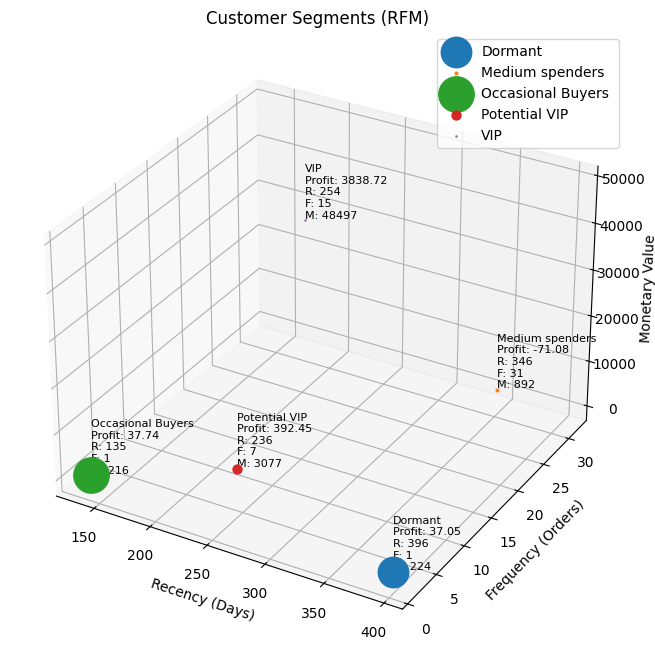

In [ ]:
# Bubble plot of segements

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Group data by cluster and calculate means
cluster_means = customer_rfm.groupby('Cluster_Name').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Profit':'mean'
})

# Get cluster counts for bubble size
cluster_counts = customer_rfm.groupby("Cluster_Name")['Cluster'].count()

# Plot centroids with annotations
for cluster_name, data in cluster_means.iterrows():
    x = data['Recency']
    y = data['Frequency']
    z = data['Monetary']
    size = cluster_counts[cluster_name] * 0.01 # Scale bubble size for better visibility

    ax.scatter(x, y, z, s=size, label=cluster_name)

    annotation = f"{cluster_name}\nProfit: {data['Profit']:.2f}\nR: {data['Recency']:.0f}\nF: {data['Frequency']:.0f}\nM: {data['Monetary']:.0f}"
    ax.text(x, y, z, annotation, fontsize=8, ha='left', va='bottom')

# Set labels and title
ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency (Orders)')
ax.set_zlabel('Monetary Value')
ax.set_title('Customer Segments (RFM)')

# Display legend
ax.legend()

plt.show()


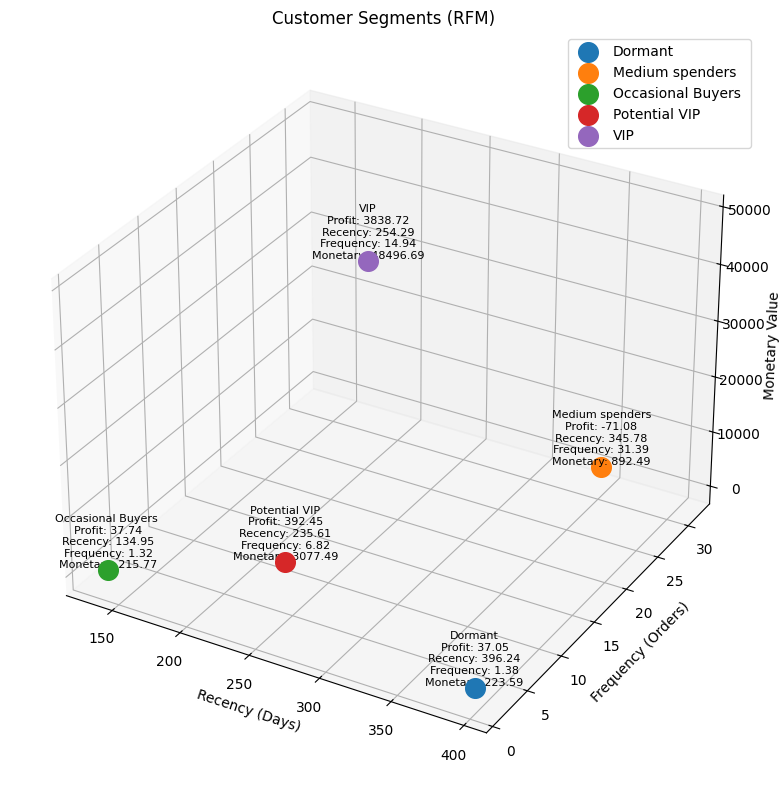

In [ ]:
# Segment Centroid Plot

# Calculate cluster centroids
centroids = customer_rfm.groupby('Cluster_Name').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean', 'Profit': 'mean'})

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot centroids with labels and annotations
for cluster, centroid in centroids.iterrows():
    ax.scatter(centroid['Recency'], centroid['Frequency'], centroid['Monetary'], s=200, marker='o', label=cluster)
    ax.text(centroid['Recency'], centroid['Frequency'], centroid['Monetary'],
            f'{cluster}\nProfit: {centroid["Profit"]:.2f}\nRecency: {centroid["Recency"]:.2f}\nFrequency: {centroid["Frequency"]:.2f}\nMonetary: {centroid["Monetary"]:.2f}',
            fontsize=8, ha='center', va='bottom')


# Set axis labels and title
ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency (Orders)')
ax.set_zlabel('Monetary Value')
ax.set_title('Customer Segments (RFM)')

# Add legend
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Aggregate category purchases per cluster
category_cluster_data = customer_rfm.groupby(['Cluster_Name', 'product_category_name'])['order_id'].count().reset_index()

# Pivot for visualization
category_cluster_pivot = category_cluster_data.pivot(index='product_category_name', columns='Cluster_Name', values='order_id').fillna(0)

# Plot category preferences by cluster
plt.figure(figsize=(8, 6))
sns.heatmap(category_cluster_pivot, cmap="coolwarm", linewidths=0.5, annot=True, fmt=".0f")
plt.title("Category Preferences by Customer Segment (Cluster)")
plt.xlabel("Customer Cluster")
plt.ylabel("Product Category")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show(10)

# EXPORT SEGMENTED DAA FOR ANALYSIS

In [ ]:
customer_rfm.to_csv('segemented_Data_rfm.csv', index=False)